# CHEM 60 - February 7th, 2024 (Regression)

Today, we are continuing with stats to get a handle on regression (more curve fitting is in your future, so don't worry if you leave this homework wanting more complex fitting routines in your life).

To get started, click on '**File**' in the left menu, then '**Save a copy in Drive**' to ensure you are editing *your* version of this assignment (if you don't, your changes won't be saved!). After you click '**Save a copy in Drive**' a popup that says **Notebook copy complete** should appear, and it may ask you to <font color='blue'>**Open in a new tab**</font>. When open, your new file will be named `Copy of CHEM60_Class_6_SP24_Mostly_Linear_Regression.ipynb` (you may want to rename it before/after you move it to your chosen directory).

#Imports

Here are the Python imports that we will need today. A tiny bit of default formatting is thrown in here (I like my font sizes to be larger than the default settings).

Run the below code block to get started.

In [5]:
# Standard library imports
import math as m

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This part of the code block is telling matplotlib to make certain font sizes exra, extra large by default
# Here is where I list what parametres I want to set new defaults for
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
# This line updates the default parameters of pyplot (to use our larger fonts)
plt.rcParams.update(params)

No data to load for the in-class time, so you're ready to go now.

# Regression

Today's class aims to introduce you to a widely used technique: regression analysis. Regression lets us do all kinds of things - from calibrating instruments to drawing conclusions from all manner of diverse datasets, measured and simulated. Chemical instrumentation, for example, often needs to analyze large numbers of samples with unknown concentrations of molecules and figure out how much of each molecule is in the sample and how confident we are in our assessment. Regression is also the broad category of techniques that let us create lines of best fit that have applications far beyond calibrating instruments (we'll start with thinking about instrumental calibration because it's a friendly place to start).

# Calibration Curves

Let's start with the classic regression example: calibration curves. A calibration curve is a graphical tool used in analytical chemistry to determine the concentration of unknown substances based on a set of standards with known concentrations. It's created by plotting the response signal of an instrument against the known concentrations of these standards, often resulting in a straight line. The equation of the "line of best fit" for this data can then be used to calculate the concentration of unknown samples. The basic process: first, we need samples of the compound of interest with a known concentration (ideally, six or more!). Next, we run those standards through whatever instrumental setup we plan to use for our unknown samples. Then, we plot the known concentration versus the signals from our instrument (I am being intentionally vague as many kinds of instruments that produce many kinds of signals can be calibrated this way). This graph (and the equation we draw from it) subsequently serves to identify the analyte concentrations in test samples, accomplished through interpolation (we'll talk about extrapolation later, too).

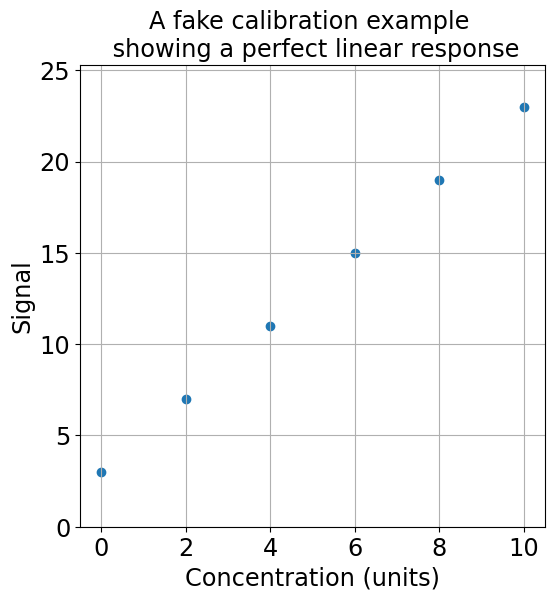

In [6]:
# Define the concentration values
concentration = np.linspace(0, 10, 6)

# A linear relationship between concentration and signal, for instance, signal = 2*concentration + 3
signal = 2 * concentration + 3

plt.figure(figsize=(6,6))
plt.scatter(concentration, signal)
plt.xlabel('Concentration (units)')
plt.ylabel('Signal')
plt.ylim([0,signal.max()+signal.max()/10]) # Why did I do this?
plt.title('A fake calibration example \n showing a perfect linear response')
plt.grid(True)
plt.show()

When we make a calibration plot (like the fake one above), we need to answer several questions before we can really use it.

* Does the calibration graph show a straight line or something else?
* Since each point on the graph can have errors, how can we find the best line or curve through these points?
* If the graph is a straight line, what are the errors and limits of the slope and intercept?

There are several, often unspoken, assumptions in the standard methods of plotting and using calibration curves. We generally assume errors/variability is in the y-values, not the x-values. This imagines we prepare our samples perfectly every time. We don't... but this expectation can often hold in regular instrumental analyses. It's usually possible to prepare standards with minimal error, whereas the instrument readings could vary a few percent. So, if the x-axis error is insignificant compared to the y-axis one, this is a fine thing to do.

We also assume that our instrumental response, for a given concentration, would produce a normally distributed dataset (only random error present). It is also sometimes assumed that the analyte concentration does not impact the size of the random errors in y-values (this is not always true, and we will talk about "weighted" regression later)

Let's start with the basics. A straight-line calibration curve. It will take the form:
\begin{align}
y=a+bx
\end{align}
where $b$ is the slope and $a$ is the intercept on the y-axis.




## r values

Question the first: is our plot linear?

Let's say we create a calibration curve. Before we fit a straight line to it, we should be sure we actually *have* a straight line. You've probably all plotted an $R^2$ coefficient before. Let's talk about what it actually means. We're going to call it its formal name - the **product–moment correlation
coefficient**, $r$.
\begin{align}
r = \frac{\displaystyle{\sum_{i=1}^{n}}\left[(x_i-\bar{x})(y_i-\bar{y})\right]}{\sqrt{ \left[ \displaystyle{\sum_{i=1}^{n}}(x_i-\bar{x})^2 \right] \left[ \displaystyle{\sum_{i=1}^{n}}(y_i-\bar{y})^2 \right]}}
\end{align}

In this formula:
- $x_i$ and $y_i$ are individual data points indexed with i,
- $\bar{x}$ and $\bar{y}$ are the means of the x (concentration) and y (signal) datasets, respectively,
- $r$ is the correlation coefficient.
- The sums run from $i = 1$ to $n$, where $n$ is the total number of data points.

The numerator, when divided by the number of data points (or $n-1$, like last week), has a special name - the covariance (if $x$ = $y$, this is just the variance!):

\begin{align}
\text{Cov}(x,y) = \frac{\displaystyle{\sum_{i=1}^{n}}\left[(x_i-\bar{x})(y_i-\bar{y})\right]}{n}
\end{align}

The covariance quantifies how changes in one variable correspond with changes in another. We'll talk more about this concept later.


Let's make a function to find this $r$ value.

In [7]:
# assumes x and y are numpy arrays
def calculate_r(x, y):
    # Calculate the mean of x and y
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    # Calculate the sum of (x - x_bar)(y - y_bar)
    numerator = np.sum((x - x_bar) * (y - y_bar))

    # Calculate the square root of the sum of (x - x_bar)^2 times the sum of (y - y_bar)^2
    denominator = np.sqrt(np.sum((x - x_bar)**2) * np.sum((y - y_bar)**2))

    # Calculate r using the above formula
    r = numerator / denominator

    if denominator == 0: return 0
    return r

## Remembering what $r$ means

By it's definition, $r$ is bound between -1 and 1. We can see some examples below where we test out the above function.

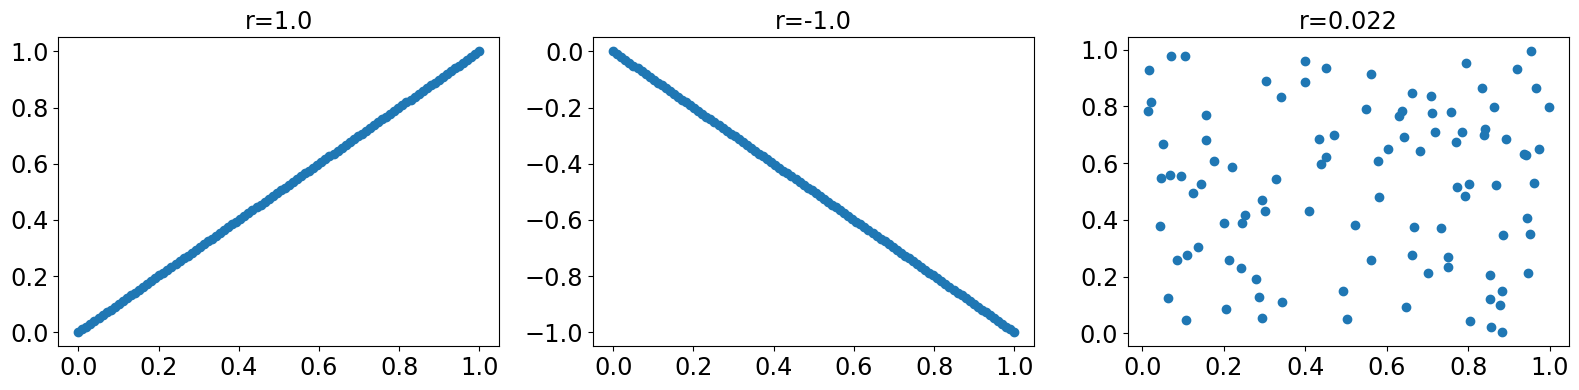

In [8]:
# Data with correlation coefficient of r=1
x1 = np.linspace(0, 1, 100); y1 = x1

# Data with correlation coefficient of r=-1
x2 = np.linspace(0, 1, 100); y2 = -x2

# Data with correlation coefficient of r~0
x3 = np.random.rand(100); y3 = np.random.rand(len(x3))

fig, axs = plt.subplots(1, 3, figsize=(16,4))

# Plot for r=1
axs[0].scatter(x1, y1)
axs[0].set_title('r='+str(calculate_r(x1, y1)))

# Plot for r=-1
axs[1].scatter(x2, y2)
axs[1].set_title('r='+str(calculate_r(x2, y2)))

# Plot for r~0
axs[2].scatter(x3, y3)
axs[2].set_title('r='+str(round(calculate_r(x3, y3),3)))

# Display the plot
plt.tight_layout()
plt.show()

As shown above, an $r$ value of +1 represents perfect positive correlation (`y1 = x1`, meaning all the data points fall precisely on a positively sloped straight line. On the other hand, when $r$ is -1, there's perfect negative correlation with all points neatly aligned on a line with negative slope (`y2 = -x2`). If there's no linear correlation between x and y, the r value will be near zero (this is the intent with the randomly distributed `x3` and `y3`s).

# PRACTICE QUESTION: Calculate the correlation coefficient, r, and plot a calibration curve

Standard aqueous solutions of Rhodamine B are examined in a UV-Vis spectrometer, and they yield the below absorbance readings (in arbitrary units - I made these up!). Determine the correlation coefficient, `r`, and plot the calibration curve.



---



In [9]:
Absorbance_readings = np.array([1.3, 3.4, 6.5, 9.7, 13.0, 15.7, 18.6])
Concentrations_in_µg_per_ml = np.array([0, 1, 2, 3, 4, 5, 6])

# calculate and plot the thing!



---
# Anscombe's quartet

One thing that I will emphasize throughout this course is that we can't just rely on statistics, we need to plot the data first. A great example for why this is true comes in the form of Anscombe's quartet. All four datasets have the same or nearly same means, variances, correlations and regression lines. However, when plotted, it's clear that each dataset tells a different story.

Let's look at them below:

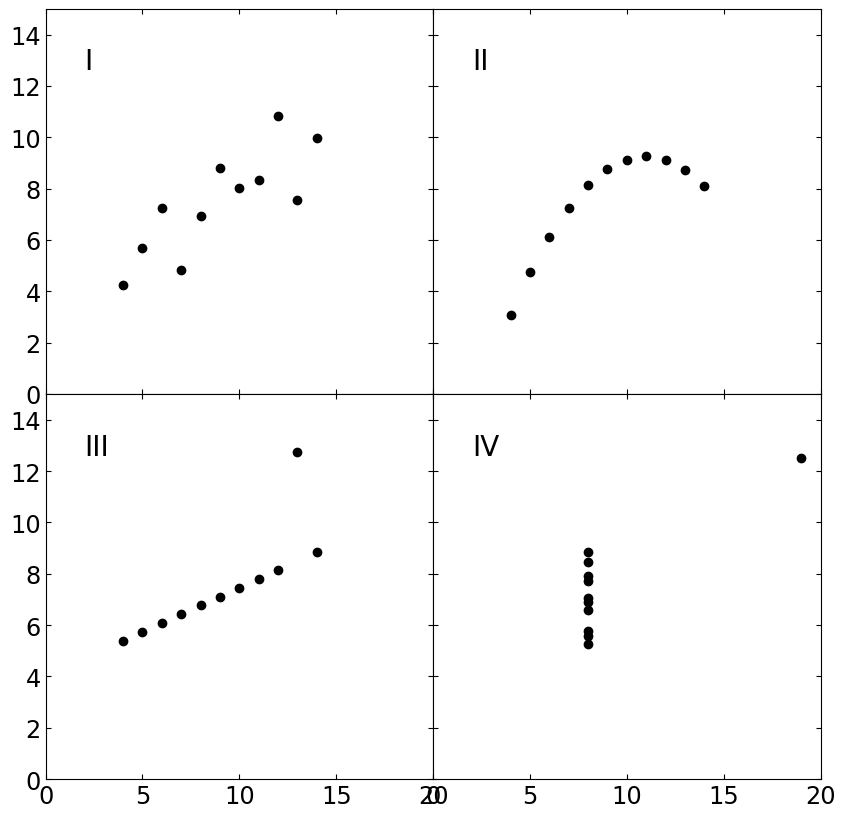

In [10]:
# Anscombe's quartet
x1 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    "I": (x1, y1),
    "II": (x1, y2),
    "III": (x1, y3),
    "IV": (x4, y4)
}

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10),
                        gridspec_kw={'wspace': 0, 'hspace': 0})

for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x, y, 'ko')
    ax.set_xlim([0,20])
    ax.set_ylim([0,15])
plt.show()

* The first dataset shows a linar relationship between two variables (it would be a disappointing calibration curve, but it looks distinctly linear)
* The second dataset is not linear, but also clearly shows a relationship between the two variables. Because that relationship isn't linear, our simple correlation coefficient is not a good way to summarize the relationship between $x$ and $y$ .
* The third dataset seems to be a perfect line of points except for one obvious outlier. This outlier affects the correlation coefficient and regression line significantly.
* The fourth dataset has an x-value which is mostly the same except for one value. This outlier results in a surprisingly high correlation coefficient, even though the relation between $x$ and $y$ isn't linear.

So, despite the similar statistical properties, we would draw very different conclusions about the relationship between x and y in each case by looking at the data.

Let's check all the basic stats here to make sure we agree. Let's grab our functions from last week too.

In [11]:
def mean_function(data):
  n = len(data)
  mean = sum(data)/n
  return mean

# let's just return the variance this time
def variance_function(data):
  n = len(data)
  mean = mean_function(data)
  variance = sum((xi - mean) ** 2 for xi in data) / (n - 1)
  return variance

To test the basic stats, let's do the first statistical moment first (the mean). This dataset has 2 $x$s and 4 $y$s to look at.

In [12]:
mean_function(x), mean_function(x4)

(9.0, 9.0)

The two $x$s we have have the same mean. What about the $y$s?

In [13]:
mean_function(y1), mean_function(y2), mean_function(y3), mean_function(y4)

(7.500909090909093, 7.500909090909091, 7.500000000000001, 7.50090909090909)

Yup. Close enough.

What about the variance?

# PRACTICE QUESTION: Check that the variance in x-values is the same and the variance in y-values is the same?

---



In [14]:
# some code! use the variance function



---



Okay. What about the $r$ value? That tells us how linearly related our variables are, right?

# PRACTICE QUESTION: Calculate the r value for each of the four variable pairs plotted above and talk with your neighbours about what it means.

Remember, we call our function like: `calculate_r(x, y1)`

In [15]:
calculate_r(x1, y1), calculate_r(x1, y2), calculate_r(x1, y3), calculate_r(x4, y4)

(0.81642051634484, 0.8162365060002427, 0.8162867394895981, 0.816521436888503)

**some reflection**



---

Okay, so hopefully are are all on board with needing to *look* at the data, not just calculate an $r$ value and call it a day.


# Lines of best fit

Our plots above looked like they were missing something - a line of best fit. It is rare to calculate an $r$ value for a scatter plot and not plunk a line showing that linear relationship. In this section, we're going to assume that a linear relationship exists between the analytical signal ($y$) and the concentration ($x$), and we'll illustrate how to compute the 'best' straight line through the points on the calibration graph. Each of these points is subject to experimental error. Since we're currently assuming all errors are situated in $y$, we're looking for the line that decreases the differences in the y-direction between the experimental points and the line calculated. As some of these differences, also known as **y-residuals**, are positive and some are negative, we want to minimize the sum of the squared residuals since these are all positive. This logic helps explain why we often use the term 'least squares' for this procedure. The straight line we require is computed based on minimizing these squared residuals, and as a result, we find the line should pass through the centroid of the points.

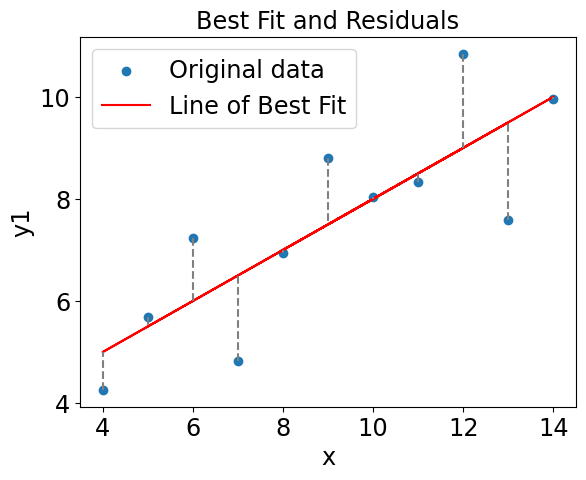

In [16]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])

# Calculate coefficients for the line of best fit
b, a = np.polyfit(x, y1, 1)

# Create line of best fit
y_fit = b * x + a

# Scatter plot of original data
plt.scatter(x, y1, label='Original data')

# Line of best fit
plt.plot(x, y_fit, 'r', label='Line of Best Fit')

# Plot residuals
for xi, y1i, y_fiti in zip(x, y1, y_fit):
    plt.plot([xi, xi], [y1i, y_fiti], color='grey', linestyle='dashed')

plt.xlabel("x")
plt.ylabel("y1")
plt.legend()
plt.title('Best Fit and Residuals')
plt.show()

Consider you have a set of $n$ data points $(x_1, y_1)$, $(x_2, y_2)$, ..., $(x_n, y_n)$, and you want to find the line $y = bx + a$ that fits best to your data.

Define the residual $e_i$ for each data point as the vertical distance from the point to the line, so $e_i = y_i - (bx_i + a)$. We want to find $b$ and $a$, which minimize the sum of squares of residuals, $E = \sum e_i^2 = Σ (y_i - bx_i - a)^2 $(this is how the least squares regression is defined).

To minimize $E$, we take partial derivatives of $E$ with respect to $b$ and $a$ (we'll talk more about partial derivatives in a few weeks), set them both to zero and solve for $b$ and $a$. This gives us the standard formula for the regression line of best fit.

This simplifies to two equations, $\sum y_i = b\sum x_i + na$ and $\sum x_i y_i = b\sum x_i^2 + a\sum x_i$, where sum represents the sum over all data points.

Solving these two equations for $a$ and $b$ will yield the intercept ($a$) and slope ($b$) of the line of best fit:

\begin{align}
b = \frac{\displaystyle{\sum_{i=1}^{n}}(x_i - \bar{x})(y_i - \bar{y})}{\displaystyle{\sum_{i=1}^{n}}(x_i - \bar{x})^2}
\end{align}

and

\begin{align}
a = \frac{\displaystyle{\sum_{i=1}^{n}}y_i - bx_i}{n}
\end{align}

We can ask Python to calculate these for us (many pre-built functions exist to do this - in fact, I used `polyfit` from `numpy` above, but they're easy to write ourselves).



In [17]:
def calculate_slope(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    b = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    return b

def calculate_intercepts(x,y):
  x_mean = np.mean(x)
  y_mean = np.mean(y)
  b = calculate_slope(x, y)
  a = y_mean - b*x_mean
  return a

Let's test the code for the above plot:


In [18]:
# Test the function
ls_slope = calculate_slope(x, y1)
ls_intercept = calculate_intercepts(x,y1)
print("Slope = ", ls_slope, "and intercept = ", ls_intercept)

Slope =  0.5000909090909091 and intercept =  3.0000909090909103


What if we didn't want to use those expressions for some reason? This task happens to have a nice, analytical expression we can just use. But sometimes, we want to calculate something and don't know the formula that will find the minimum value. We can do this through a brute-force method too.

First, let's give us a function to calculate the residuals.

In [19]:
# Define function to calculate residuals
def residuals(slope, intercept, x, y):
    y_pred = slope * x + intercept
    residual = y - y_pred
    return np.sum(residual**2)

Now, let's just search and find the pair of $a$ and $b$ that minimize those residuals.

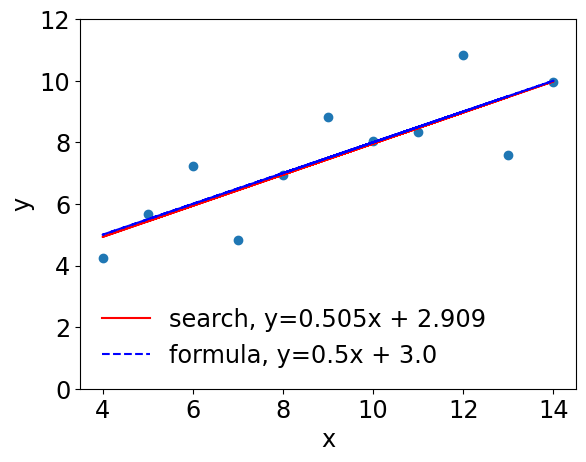

In [20]:
# Try some slopes and intercepts
slopes = np.linspace(0, 2, 100)  # range of slopes
intercepts = np.linspace(0, 12, 100) # range of intercepts

min_residuals = np.inf  # initialize to infinity
best_slope = None
best_intercept = None

for slope in slopes:
    for intercept in intercepts:
        current_residuals = residuals(slope, intercept, x, y1)
        if current_residuals < min_residuals:
            min_residuals = current_residuals
            best_slope = slope
            best_intercept = intercept


# Now plot the best fit line
y_fit = best_slope * x + best_intercept
y_least_squares = ls_slope * x + ls_intercept
plt.scatter(x, y1)
plt.plot(x, y_fit, color='red', label = 'search, y='+str(round(best_slope,3))+'x + '+str(round(best_intercept,3)))
plt.plot(x, y_least_squares, color='blue', linestyle='--',label= 'formula, y='+str(round(ls_slope,3))+'x + '+str(round(ls_intercept,3)))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12])
plt.legend(frameon=False)
plt.show()

These lines:
```
slopes = np.linspace(0, 2, 100)  # range of slopes
intercepts = np.linspace(0, 12, 100) # range of intercepts
```
Created 100 different slopes and 100 different intercepts to try within a given range (we needed to have a decent initial guess as to where these values could lie). Our 'search' attempt did a decent job, but not perfect.


# PRACTICE QUESTION: Try the search again with a larger number of values (say 1000) and a smaller number (say 10) and think about why we might not want to do this (when we don't have to).


---



In [21]:
#



---


There are more efficient ways to do brute-force search tasks like this (some invented by chemists, in fact!) and we'll get to them later.

What if we didn't know how to find expressions for $b$ and $a$ analytically though? What if we thought our residuals took a more complex form?

Let's look at the second member of the quartet, that kind of looks like a parabola.

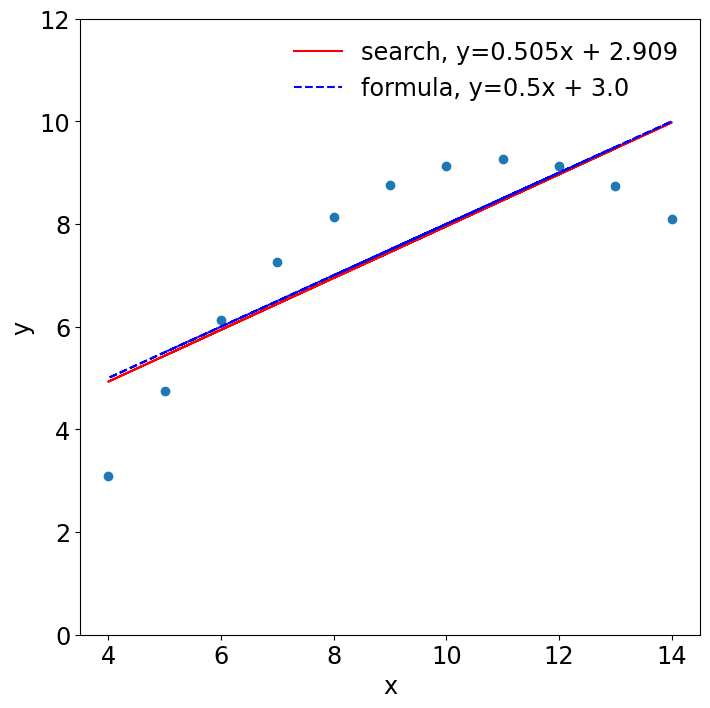

In [22]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])

# Try some slopes and intercepts
slopes = np.linspace(0, 2, 100)  # range of slopes
intercepts = np.linspace(0, 12, 100) # range of intercepts

min_residuals = np.inf  # initialize to infinity
best_slope = None
best_intercept = None

for slope in slopes:
    for intercept in intercepts:
        current_residuals = residuals(slope, intercept, x, y2)
        if current_residuals < min_residuals:
            min_residuals = current_residuals
            best_slope = slope
            best_intercept = intercept

# the fit
y_fit = best_slope * x + best_intercept
y_least_squares = ls_slope * x + ls_intercept

# Now plot the best fit line
plt.figure(figsize=(8,8))
plt.scatter(x, y2)
plt.plot(x, y_fit, color='red', label = 'search, y='+str(round(best_slope,3))+'x + '+str(round(best_intercept,3)))
plt.plot(x, y_least_squares, color='blue', linestyle='--',label= 'formula, y='+str(round(ls_slope,3))+'x + '+str(round(ls_intercept,3)))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12])
plt.legend(frameon=False)
plt.show()

The linear fit is obviously wrong here, so let's try guessing a different form for the equation. Looks like a parabola to me!

In [23]:
#y=ax^2+bx+c
def para_residuals(a, b, c, x, y):
    y_pred = a * x**2 + b* x + c
    residual = y - y_pred
    return np.sum(residual**2)

Now, let's minimize those residuals

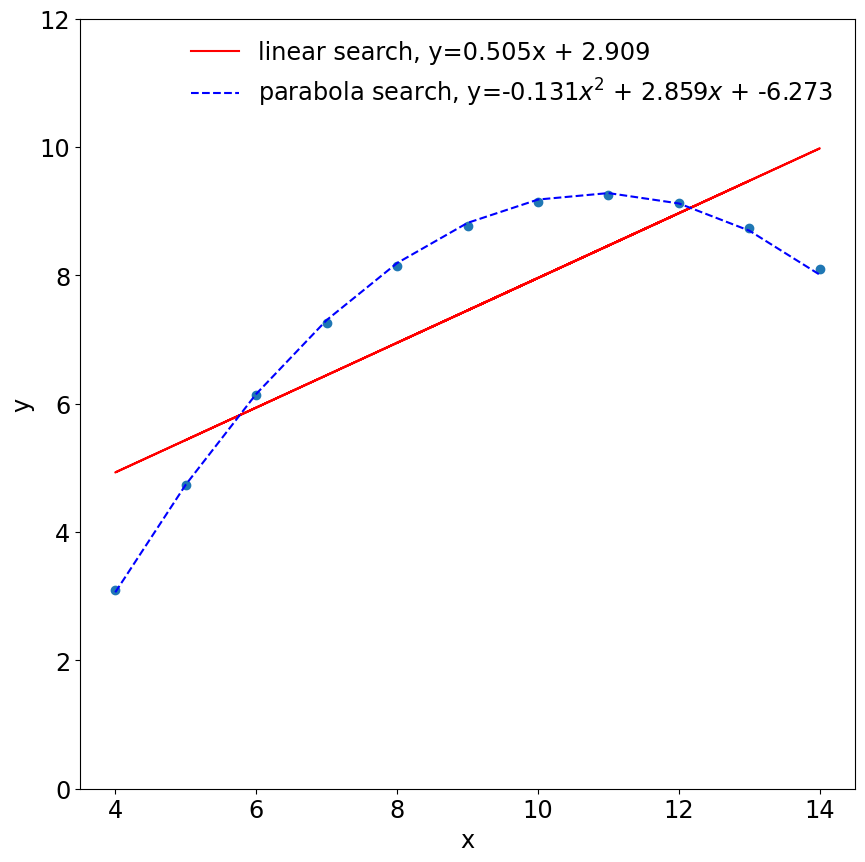

In [24]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])

# Try some values
a_values = np.linspace(-1, 1, 100)  # range of a
b_values = np.linspace(2, 3, 100) # range of b
c_values = np.linspace(-7, -5, 100) # range of c

min_residuals = np.inf  # initialize to infinity
best_a = None
best_b = None
best_c = None

for a in a_values:
    for b in b_values:
      for c in c_values:
        current_residuals = para_residuals(a, b, c, x, y2)
        if current_residuals < min_residuals:
            min_residuals = current_residuals
            best_a = a
            best_b = b
            best_c = c


# Assign x- and y-para-fit after sorting x
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y_para_fit = best_a * x_sorted**2 + best_b* x_sorted + best_c

# Now plot the best fit line
plt.figure(figsize=(10,10))
plt.scatter(x, y2)
plt.plot(x, y_fit, color='red', label = 'linear search, y='+str(round(best_slope,3))+'x + '+str(round(best_intercept,3)))
plt.plot(x_sorted, y_para_fit, color='blue', linestyle='--',label= 'parabola search, y='+str(round(best_a,3))+'$x^2$ + '+str(round(best_b,3))+'$x$ + '+str(round(best_c,3)))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12])
plt.legend(frameon=False)
plt.show()

So yes, this was inefficient. But it is also powerful. You can look at data, make a decent guess as the the shape of curve you want, and find a solution that works. Sometimes, this method is the best we have. For linear applications though, the simple and familar least squares line is the way to go.

# Errors associated with regression

Say we used the nice equation to find a linear line of best fit and we want to know the errors associated with using it (say we plan to interpolate concentrations).

The equation for this is found to use the y-residuals, where the $y_i$ are the measured $y$ values and $\hat{y_i}$ are the fitted $y$ values for the same $x_i$. We can create something known as the residual standard error, ($s_{y/x}$), which estimates the random errors along the y-direction.

\begin{align}
s_{y/x} = \sqrt{\frac{\sum(y_i - \hat{y_i})^2}{n-2}}
\end{align}

Why $n-2$? For every data point, we have a pair of (x, y) values. When estimating the parameters of our line (slope and intercept), we are essentially 'using up' two degrees of freedom from our sample. This leaves us with $n-2$ degrees of freedom to estimate the variability.

Now, with the $s_{y/x}$ value at hand, we can work out standard deviation for the slope and intercept as:
\begin{align}
s_b=\frac{s_{y/x}}{\sqrt{\displaystyle{ \sum_i \left( x_i - \bar{x} \right) }}}
\end{align}
and
\begin{align}
s_a=s_{y/x}\sqrt{\frac{\displaystyle{\sum_i x_i^2}}{n \displaystyle{ \sum_i \left( x_i - \bar{x} \right)^2 }}}
\end{align}

How do these let us think about error? Or confidence in a regression curve?

## Standard error of the mean

Recall from last week our fun with histograms and the thinking we were doing about different distributions.

When plotting repeated measurements, we expect a normal distribution in the absence of systematic error. Then, the mean of a sample measurement estimates the true value we're measuring. However, because individual measurements can vary due to random errors, the mean isn't always equal to the true value. Thus, it's usually more beneficial to provide a range of likely values. The width of this range depends on the precision of measurements and the number of measurements in the sample. Repeated measurements give us greater confidence in our estimate of the true value. To get at this, we use the notion of standard error.


\begin{align}
\text{standard error of the mean} = \sigma/\sqrt{n}
\end{align}

We are normalizing the variance by the number of samples in our dataset. The larger $n$ is (ie. the more times we measured the thing), the lower our notion of error will be. This feels logical but isn't quite enough on its own to think of error associated with regression.


# Confidence intervals

Many of you noted the 'confidence intervals' used in the bee paper. The term' confidence' suggests that we can state, with a specific level of probability (confidence?), that a true value falls within the a given interval. The confidence interval's size will depend on how sure we want to be that it contains the true value. The higher our desired level of certainty, the wider the interval needs to be. This idea is connected to the standard error concept above. Let's look at our simulated normal distribution from last week.

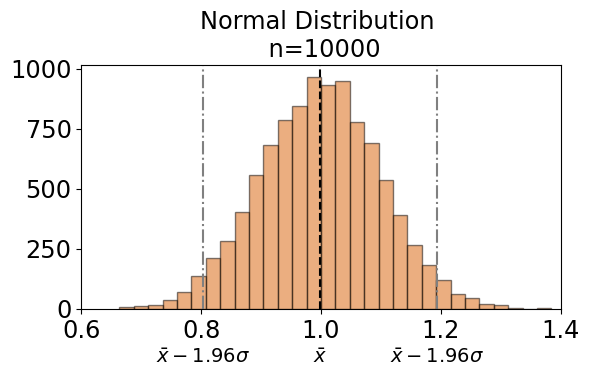

In [25]:
# Generate normally distributed random numbers
fake_measurement = np.random.normal(1, .1, 10000)

# Now the plot
fig, ax = plt.subplots(figsize=(6, 4))

# our basic stats
mean = np.mean(fake_measurement)
stddev = np.std(fake_measurement)

# Create histogram for the data
ax.hist(fake_measurement, bins=30, alpha=0.5, facecolor='#d95f02', edgecolor='black', align='mid')

# Add mean to the plot
ax.axvline(mean, color='k', linestyle='--')

# Add standard deviation to the plot
ax.axvline(mean - 1.96*(stddev), color='grey', linestyle='-.')
ax.text(mean, ax.get_ylim()[1]*-0.2, '$\\bar{x}$', fontsize=14, ha='center', va='center')
ax.axvline(mean + 1.96*(stddev), color='grey', linestyle='-.')
ax.text(mean - 1.96*(stddev), ax.get_ylim()[1]*-0.2, '$\\bar{x} - 1.96\sigma$', fontsize=14, ha='center', va='center')
ax.text(mean +  1.96*(stddev), ax.get_ylim()[1]*-0.2, '$\\bar{x} - 1.96\sigma$', fontsize=14, ha='center', va='center')
ax.set_title('Normal Distribution \n n='+str(len(fake_measurement)))

ax.set_xlim([.6, 1.4])

plt.tight_layout()
plt.show()

Constructing confidence intervals is deeply tied to the properties of normal distributions. Many test statistics follow a normal distribution (or a t-distribution, which is approximately normal for large samples), a trait reinforced by the Central Limit Theorem, which states that the sum or average of a large number of measurements will follow a normal distribution, regardless of their initial distribution.

This important property allows us to define confidence intervals using the standard deviation of the distribution. For a normal distribution, roughly 68% of the data falls within one standard deviation of the mean, 95% within ~two standard deviations, and 99.7% within ~three standard deviations. We can tweak these properties to contrive confidence intervals for a mean that corresponds to various levels of confidence (e.g. 95% confidence or 99% confidence). Confidence intervals use the standardized properties of normal distributions to give us a quantitative measure of the assertiveness we may possess regarding our estimates.

If we calculate a 95% confidence interval for a parameter, we're expressing that if we were to replicate the data collection process many times, then 95% of the times, the confidence interval calculated would contain the true value of the parameter. Hence, confidence intervals are pivotal in data analysis, as they provide a range for parameter estimation instead of a singular point estimate, lending a degree of certainty to our findings.

Scenarios such as sampling, hypotheses testing, regression analysis, and more become more understandable and manageable when we think in terms of confidence intervals. This is why you see them all other experimental chemistry.

Because we have artificially created a normal distribution, we know that the above-dashed lines contain 95% of the samples in the dataset (we could integrate this to check - but we'll save integration for another day).

## Confidence interval of the mean

Using the properties of normal distributions, we can formalize what we mean by confidence interval. If $\mu$ is the "true" value, and $\bar{x}$ is the measured mean, we can assume the 95% confidence interval is:
\begin{align}
\bar{x} - 1.96\left(\sigma/\sqrt{n}\right) < \mu < \bar{x} + 1.96\left(\sigma/\sqrt{n}\right)
\end{align}
So, we are 95% sure the true value is bounded by the above.

For large samples, this basic formula holds:
\begin{align}
\bar{x} - z\left(\sigma/\sqrt{n}\right) < \mu < \bar{x} + z\left(\sigma/\sqrt{n}\right)
\end{align}

Where $z = 1.96$ for the 95% confidence interval, $z = 2.58$ for the 99% confidence interval, and $z = 2.97$ for the 99.7% confidence interval.

# PRACTICE QUESTION: Calculate the 95% and 99% confidence limits of the mean for our fake distribution above

Confidence intervals are usually presented as $\bar{x} \pm \text{a number } (\text{the percent})$. Things that might be useful to remember:
* $n =$ `len(fake_measurement)`
* $\bar{x} =$ `mean`
* $\sigma = $ `stddev`


---



In [26]:
# calculate the thing!

**maybe practice your $LaTeX$ here to write it out too!**

## Confidence intervals for small datasets

Let's look at our fake normal distrubution again, but only allow 11 points to be included. It... won't look that normal (but we know the data was drawn from a normal distribution).

In [27]:
def standard_deviation_function(data):
  n = len(data)
  mean = mean_function(data)
  variance = sum((xi - mean) ** 2 for xi in data) / (n - 1)
  return m.sqrt(variance)

And make our plot

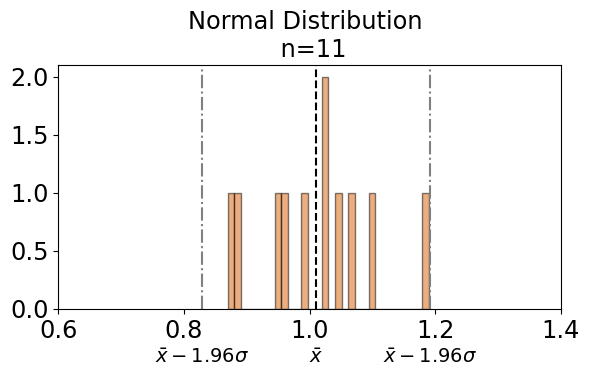

In [28]:
# Generate normally distributed random numbers
fake_measurement = np.random.normal(1, .1, 11)

# Now the plot
fig, ax = plt.subplots(figsize=(6, 4))

# our basic stats
mean = mean_function(fake_measurement)
stddev = standard_deviation_function(fake_measurement)

# Create histogram for the data
ax.hist(fake_measurement, bins=30, alpha=0.5, facecolor='#d95f02', edgecolor='black', align='mid')

# Add mean to the plot
ax.axvline(mean, color='k', linestyle='--')

# Add standard deviation to the plot
ax.axvline(mean - 1.96*(stddev), color='grey', linestyle='-.')
ax.text(mean, ax.get_ylim()[1]*-0.2, '$\\bar{x}$', fontsize=14, ha='center', va='center')
ax.axvline(mean + 1.96*(stddev), color='grey', linestyle='-.')
ax.text(mean - 1.96*(stddev), ax.get_ylim()[1]*-0.2, '$\\bar{x} - 1.96\sigma$', fontsize=14, ha='center', va='center')
ax.text(mean +  1.96*(stddev), ax.get_ylim()[1]*-0.2, '$\\bar{x} - 1.96\sigma$', fontsize=14, ha='center', va='center')
ax.set_title('Normal Distribution \n n='+str(len(fake_measurement)))

ax.set_xlim([.6, 1.4])

plt.tight_layout()
plt.show()

Decent chance, the above figure shows some very unhelpful lines - those dashed lines probably don't look like they're describing a particularly descriptive region of data. This is also a problem when assigning confidence intervals to small datasets (our calibration curve example, is certainly a small dataset). So what do we do?

For smaller sample sizes, the confidence limits of the mean are determined by the formula:
\begin{align}
x \pm t_{n-1,\text{%}}s/\sqrt(n)
\end{align}

The subscript ($n - 1$) denotes that the '$t$' value depends on the number of members in the dataset ($n-1$ is often referred to as the degrees of freedom). 'Degrees of freedom' here pertains to the independent calculations ($x_i-\bar{x}$) used in the calculation of '$s$'. The '$t$' value also relies on the confidence level that is needed. Common values are below:

degrees of freedom | $t_{n-1, \text{95%}}$ | $t_{n-1, \text{99%}}$
---- | ---- | ----
2 | 4.30 | 9.92
5 | 2.57 | 4.03
10 | 2.23 | 3.17
50 | 2.01 | 2.68
100 | 1.98 | 2.63

Let's try this out for the above.

In [29]:
confidental_interval_small = 2.23*standard_deviation_function(fake_measurement)/len(fake_measurement)**0.5
print(str(round(mean_function(fake_measurement),3)),"± "+str(round(confidental_interval_small,3)),"(95%)")

1.011 ± 0.062 (95%)


It makes sense that we wouldn't be so confidence with this data (there just isn't very much of it)

As $n$ increases, these $t_{n-1}$ numbers converge on the values used for large $n$ systems (which makes sense).

Thinking about the bee paper from last week, you'll recall that their measurements followed a normal distribution (and you wouldn't expect them to because they weren't repeated measurements of the same thing; they were samples from different colonies). If the measurements come from a log-normal distribution, it's crucial to consider this when calculating the confidence limits. Given that the log of log-normal measurements follows a normal distribution, using the logarithms of the measurements to calculate a confidence interval can lead to more accurate results (this is why the paper you read used the natural log of many quantities, so they could still report the statistics using the above expressions).

## Confidence intervals for lines of best fit

Let's look at this plot again. There are actually a couple of different ways to assign confidence intervals for a line of best fit. We will do the simplest today.

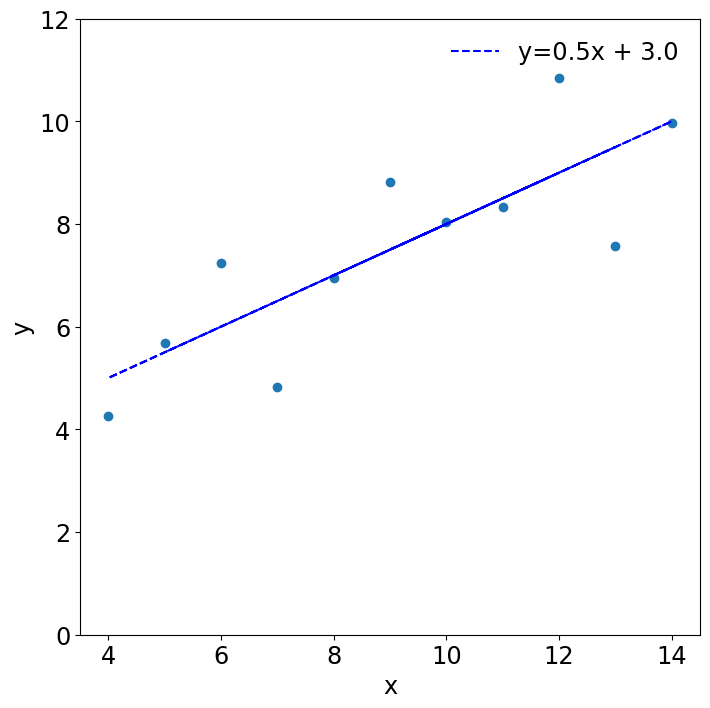

In [30]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])

ls_slope = calculate_slope(x, y1)
ls_intercept = calculate_intercepts(x,y1)
y_least_squares = ls_slope * x + ls_intercept

# Now plot the best fit line
plt.figure(figsize=(8,8))
plt.scatter(x, y1)
plt.plot(x, y_least_squares, color='blue', linestyle='--',label= 'y='+str(round(ls_slope,3))+'x + '+str(round(ls_intercept,3)))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12])
plt.legend(frameon=False)
plt.show()

 We can assign a 95% confidence interval for both the slope and intercept exactly as we did above. We have expressions for the standard deviation (and thus standard error) and can recognize that these are small datasets.

In [31]:
def s_yx(y_true, y_pred):
    n = len(y_true)
    residuals = y_true - y_pred
    return np.sqrt(np.sum(residuals**2) / (n - 2))

def s_b(s_yx, x):
    x_mean = np.mean(x)
    return s_yx / np.sqrt(np.sum((x - x_mean)**2))

def s_a(s_yx, x):
    n = len(x)
    x_mean = np.mean(x)
    return s_yx * np.sqrt(np.sum(x**2) / (n * np.sum((x - x_mean)**2)))

And now let's calculate the confidence interval (or envelope) for our regression line.

In [32]:
conf_interval_slope = 2.23*s_b(s_yx(y1, y_least_squares), x)/(len(x)-2)**0.5
print("slope = "+ str(round(ls_slope,3)),"± "+str(round(conf_interval_slope,3)),"(95%)")

conf_interval_intercept = 2.23*s_a(s_yx(y1, y_least_squares), x)/(len(x)-2)**0.5
print("intercept = "+str(round(ls_intercept,3)),"± "+str(round(conf_interval_intercept,3)),"(95%)")

slope = 0.5 ± 0.088 (95%)
intercept = 3.0 ± 0.836 (95%)


And let's plot it

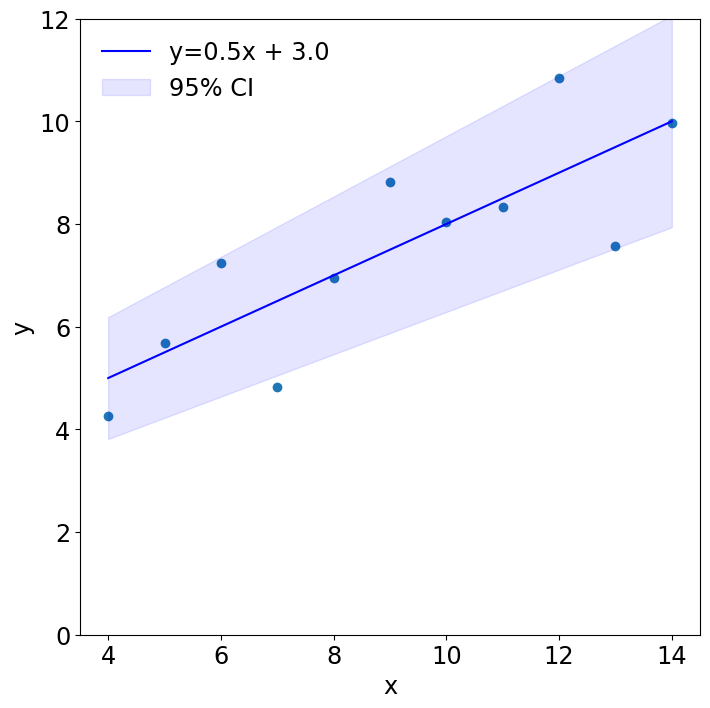

In [33]:
# Sort the arrays by x's values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y1_sorted = y1[sorted_indices]
y_least_squares_sorted = y_least_squares[sorted_indices]

# Calculate upper and lower bounds after sorting
upper_bound = y_least_squares_sorted + conf_interval_slope * x_sorted + conf_interval_intercept
lower_bound = y_least_squares_sorted - conf_interval_slope * x_sorted - conf_interval_intercept

# Plot the data
plt.figure(figsize=(8,8))
plt.scatter(x_sorted, y1_sorted)
plt.plot(x_sorted, y_least_squares_sorted, color='blue', label='y='+str(round(ls_slope,3))+'x + '+str(round(ls_intercept,3)))

# Plot the envelope
plt.fill_between(x_sorted, lower_bound, upper_bound, color='blue', alpha=.1, label="95% CI")

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12])
plt.legend(frameon=False)
plt.show()

This looks like a big confidence interval if this data were for a calibration curve - and it is. That's because this data has a lot of spread for a calibration curve! Some data does have this much spread though. Compare the above to the below approach. Something different is happening here now.

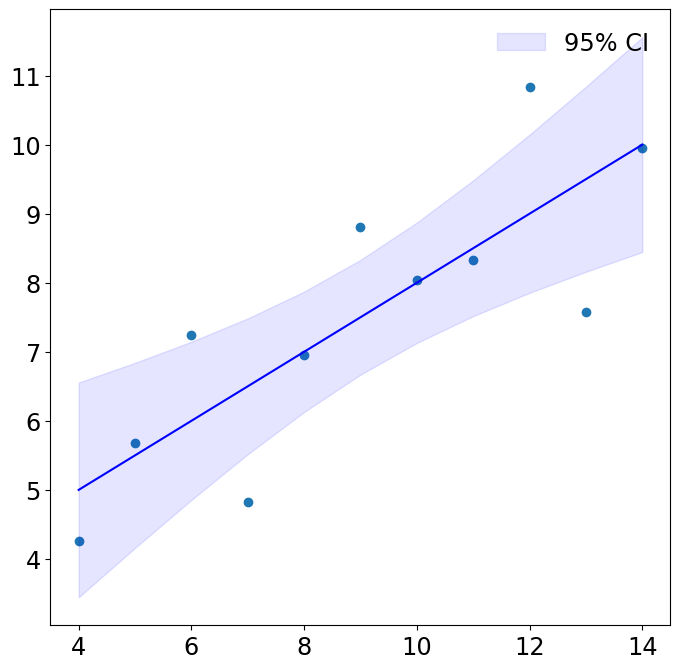

In [34]:
# Sort the arrays by x's values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y1[sorted_indices]

# calculate the y-error (residuals)
y_err = y_sorted - y_least_squares_sorted

# calculate confidence intervals
mean_x = np.mean(x_sorted)
n = len(x_sorted)
t = 2.23
s_err = np.sum(np.power(y_err,2))
confs =  t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_sorted-mean_x),2)/(np.sum(np.power(x_sorted,2))-n*(np.power(mean_x,2))))))

# get lower and upper confidence limits based on predicted y and confidence intervals
lower_bound = y_least_squares_sorted - abs(confs)
upper_bound = y_least_squares_sorted + abs(confs)

# Plot the data
plt.figure(figsize=(8,8))
plt.scatter(x_sorted, y_sorted)
plt.plot(x_sorted, y_least_squares_sorted, color='blue')

# Plot the envelope
plt.fill_between(x_sorted, lower_bound, upper_bound, color='blue', alpha=.1, label="95% CI")

plt.legend(frameon=False)
plt.show()

This is a more typical way to present confidence for a regression. What is different?

# PRACTICE QUESTION

Write out the formula being applied here and reflect on what meaning it has.


---



**here!**



---



# Submit your notebook

It's time to download your notebook and submit it on Canvas. Go to the File menu and click **Download** -> **Download .ipynb**

Then, go to **Canvas** and **submit your assignment** on the assignment page. Once it is submitted, swing over to the homework now and start working through the paper.